In [9]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Data_processing')
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, brier_score_loss, top_k_accuracy_score, balanced_accuracy_score, cohen_kappa_score, log_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import KOProcessor 
import logging
import warnings
from sklearn.calibration import calibration_curve
from scipy import interpolate
from itertools import cycle
# Add these to your existing imports:
from scipy.stats import entropy

warnings.filterwarnings('ignore')

In [10]:
# ADded changes for pipeline to run quicker, should equal 55 fits
 
param_grid = [
    {  
        'estimator': [MultiOutputClassifier(RandomForestClassifier(random_state=42))],
        'estimator__estimator__n_estimators': [100, 300],  # Reduced from [100, 200, 300]  
        'estimator__estimator__max_depth': [5, None]  # Reduced from [5, 10, 15, None]
    },
    {  
        'estimator': [MultiOutputClassifier(SVC(random_state=42, probability=True))],
        'estimator__estimator__C': [0.1, 1],  # Reduced from [0.1, 1, 10]
        'estimator__estimator__kernel': ['linear', 'rbf'], 
        'estimator__estimator__gamma': ['scale']  # Removed 'auto'
    },
    {
        'estimator': [MultiOutputClassifier(LogisticRegression())],
        'estimator__estimator__C': [0.1, 1, 10]  # Reduced from [0.01, 0.1, 1, 10, 100]
    }         
]

target_traits = ['oxygen']  # Add/remove traits as needed

In [11]:
# Load and preprocess data
terms_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_KO.zip'
terms_csv_path = 'terms_KO.csv'
traits_reduced_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
traits_reduced_csv_path = 'reducedDataset.csv'
traits_assembled_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/assembledDataset.zip'
traits_assembled_csv_path = 'assembledDataset.csv'

processor = KOProcessor(
    terms_zip_path, 
    terms_csv_path, 
    traits_reduced_zip_path, 
    traits_reduced_csv_path, 
    traits_assembled_zip_path=traits_assembled_zip_path, 
    traits_assembled_csv_path=traits_assembled_csv_path
)

ko_terms = processor.load_terms()
if ko_terms is None:
    raise FileNotFoundError("KO terms could not be loaded. Please check the file paths.")

reduced_traits_data = processor.load_reduced_traits_data()
if reduced_traits_data is None:
    raise FileNotFoundError("Reduced traits data could not be loaded. Please check the file paths.")

# Preprocess KO terms
X_terms = processor.preprocess_terms(ko_terms)

# Preprocess all target traits into a DataFrame
y_dfs = []
label_encoders = {}  # Store encoders for each trait

for trait in target_traits:
    y_trait = processor.preprocess_traits(reduced_traits_data, trait_column=trait, use_assembled_if_missing=True)
    if y_trait is not None:
        # Encode labels to numerical values
        le = LabelEncoder()
        encoded = le.fit_transform(y_trait)
        y_dfs.append(pd.Series(encoded, index=y_trait.index, name=trait))
        label_encoders[trait] = le

y_combined = pd.concat(y_dfs, axis=1).dropna()

# Align features with labels
X_aligned, Y_aligned = processor.align_data(X_terms, y_combined)

# Feature Selection: Variance Threshold
selector = VarianceThreshold(threshold=0.03)
X_aligned = selector.fit_transform(X_aligned)

# Check trait distributions
for trait in target_traits:
    print(f"\nDistribution for {trait}:")
    print(Y_aligned[trait].value_counts())

Data loaded successfully:
   Unnamed: 0   key      KO
0           0  1000  K00001
1           1  1000  K13954
2           2  1000  K00003
3           3  1000  K00013
4           4  1000  K00014
Data loaded successfully:
   key        ID                      speciesStrain  \
0    1  592010.0   Abiotrophia defectiva ATCC 49176   
1    1     219.0     Abiotrophia defectiva DSM 9849   
2    2  159837.0       Abyssibacter profundi OUC007   
3    3       NaN  Acanthopleuribacter pedis FYK2218   
4    4  258515.0   Acetanaerobacterium elongatum Z7   

                 speciesStrainComp                genus            genusComp  \
0    abiotrophiadefectivaatcc49176          Abiotrophia          abiotrophia   
1      abiotrophiadefectivadsm9849          Abiotrophia          abiotrophia   
2       abyssibacterprofundiouc007         Abyssibacter         abyssibacter   
3  acanthopleuribacterpedisfyk2218  Acanthopleuribacter  acanthopleuribacter   
4   acetanaerobacteriumelongatumz7  Acetanaerobac

Fitting 3 folds for each of 11 candidates, totalling 33 fits

Sample raw probability outputs:

First 5 samples - oxygen:
   aerobic  aerotolerant  anaerobic  conflict  facultative  microaerophilic  \
0     0.54           0.0       0.14      0.00         0.24             0.04   
1     0.55           0.0       0.06      0.02         0.23             0.08   
2     0.89           0.0       0.00      0.00         0.05             0.00   
3     0.84           0.0       0.03      0.00         0.09             0.01   
4     0.87           0.0       0.01      0.01         0.09             0.01   

   unknown  
0     0.04  
1     0.06  
2     0.06  
3     0.03  
4     0.01  

Evaluation for oxygen
Expected classes: ['aerobic', 'aerotolerant', 'anaerobic', 'conflict', 'facultative', 'microaerophilic', 'unknown']

Classification Report (all classes):
                 precision    recall  f1-score   support

        aerobic       0.00      0.00      0.00         0
   aerotolerant       0.00      0.

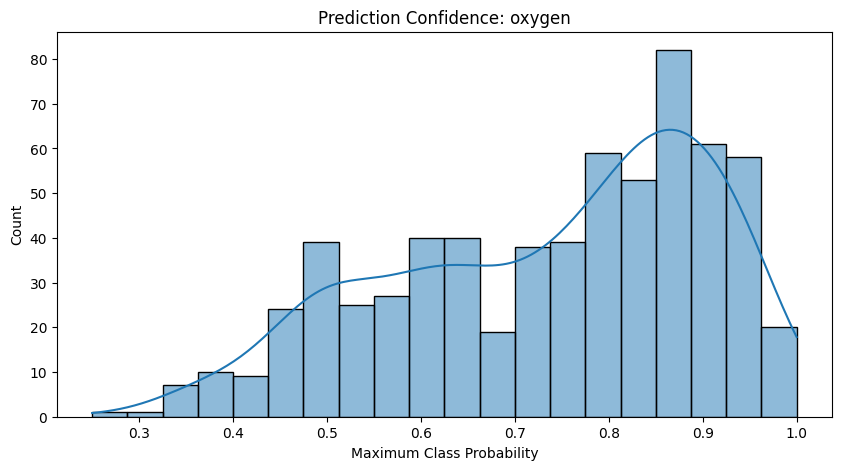

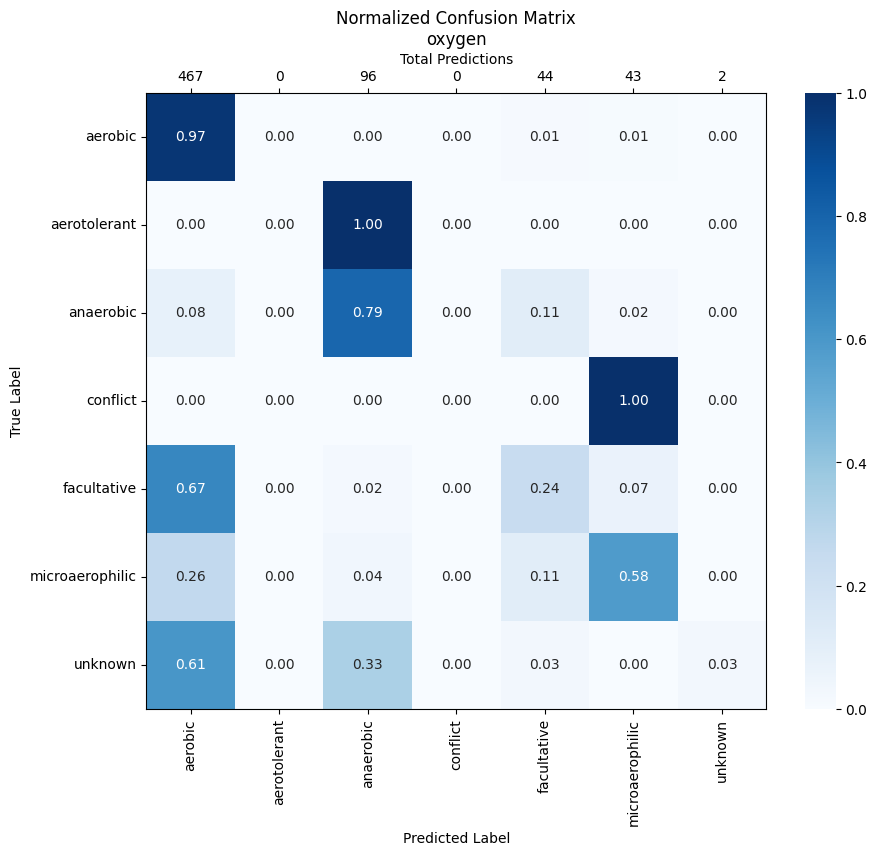

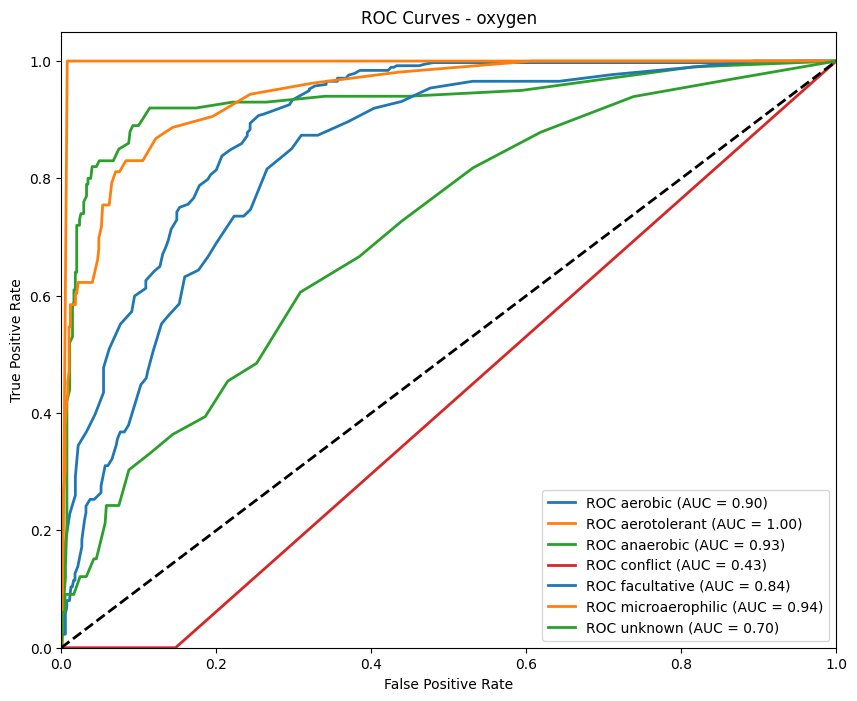

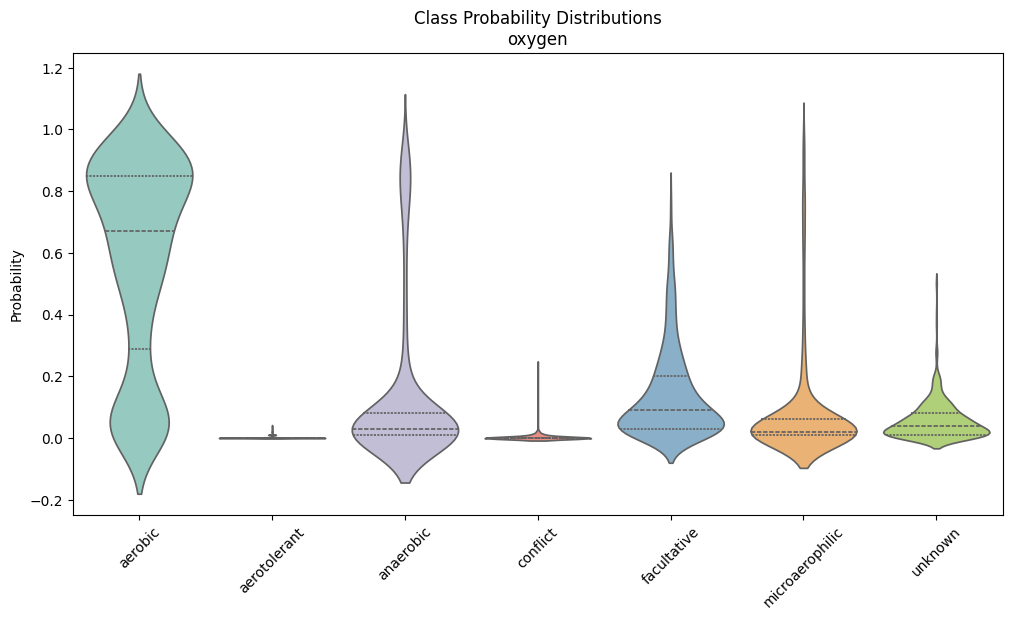

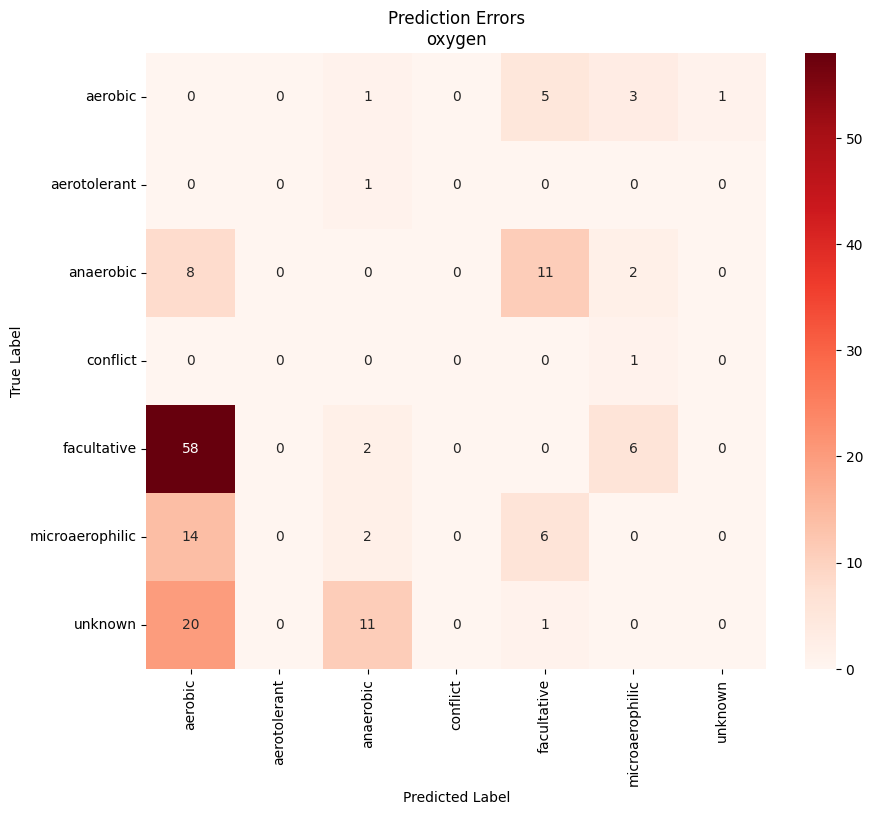

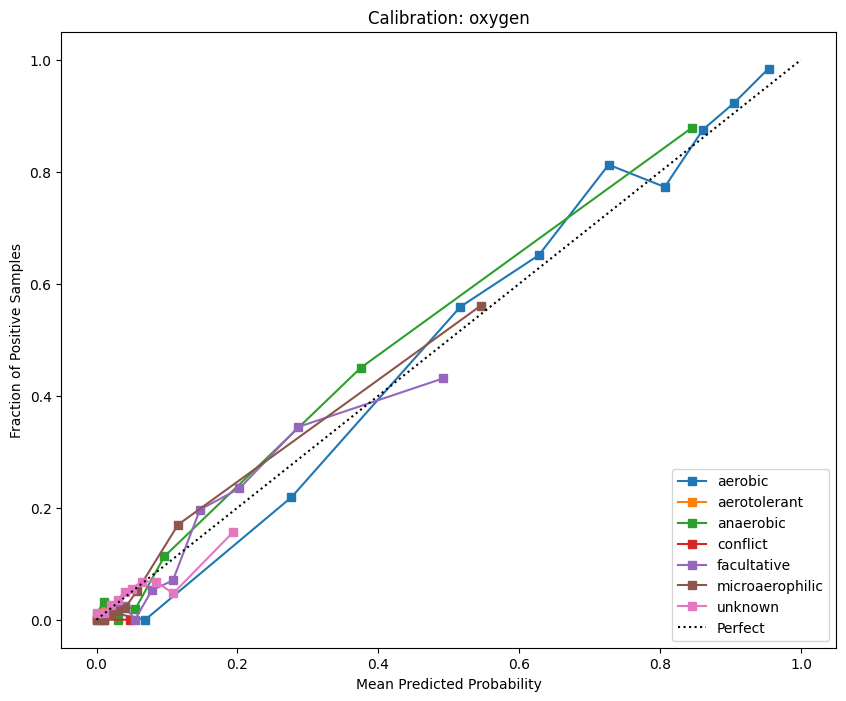

Brier Scores (Lower = Better):
                 Brier Score
aerobic             0.119123
aerotolerant        0.001485
anaerobic           0.051262
conflict            0.001780
facultative         0.094750
microaerophilic     0.039574
unknown             0.046419


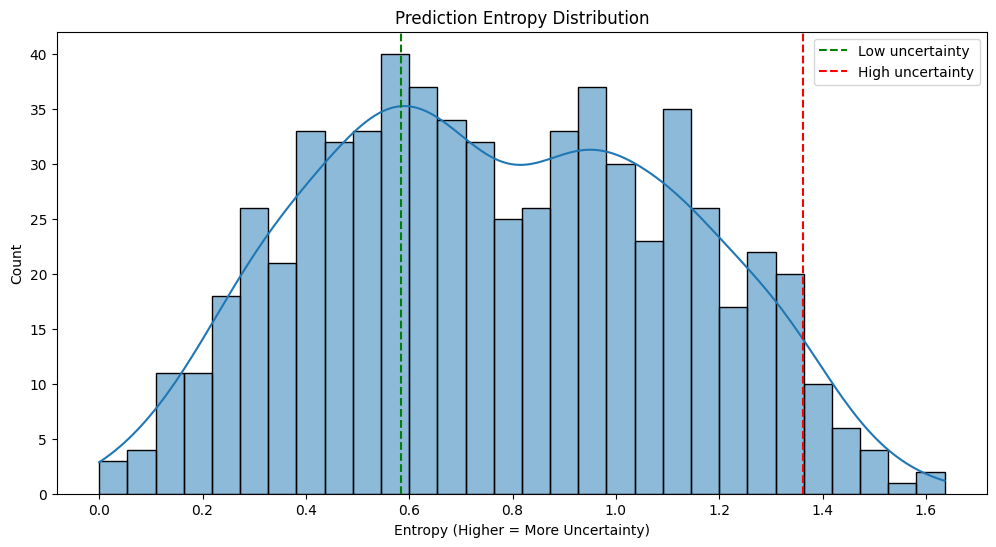

Found 23 highly uncertain predictions


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [12]:
#############################################
# Modified Functions for Multi-Output
#############################################

def plot_advanced_confusion_matrix(y_true, y_pred, classes, title):
    """Enhanced confusion matrix with normalization and counts"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Normalized Confusion Matrix\n{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add raw counts to bottom
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels([str(int(x)) for x in cm.sum(axis=0)])
    ax2.set_xlabel('Total Predictions')
    plt.show()

def plot_roc_curves(y_true, y_probs, classes, title):
    """Multiclass ROC curves with AUC scores"""
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all classes
    plt.figure(figsize=(10, 8))
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {title}')
    plt.legend(loc="lower right")
    plt.show()

def plot_class_probabilities(y_probs, classes, title):
    """Violin plot of class probability distributions"""
    prob_df = pd.DataFrame(y_probs, columns=classes)
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=prob_df, inner="quartile", palette="Set3")
    plt.title(f'Class Probability Distributions\n{title}')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.show()

def plot_feature_importance(feature_importances, feature_names, top_n=20, title=""):
    """Plot feature importance for tree-based models"""
    indices = np.argsort(feature_importances)[-top_n:]
    plt.figure(figsize=(10, 8))
    plt.title(f'Top {top_n} Feature Importances\n{title}')
    plt.barh(range(top_n), feature_importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

def plot_prediction_errors(y_true, y_pred, classes, title):
    """Error analysis: which classes are confused with others"""
    error_matrix = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(error_matrix, 0)  # Remove correct predictions
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Prediction Errors\n{title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def decode_labels(Y, label_encoders):
    """Convert numerical labels back to original text labels"""
    decoded = Y.copy()
    for trait in Y.columns:
        decoded[trait] = label_encoders[trait].inverse_transform(Y[trait])
    return decoded

# =============================================
#  Probability Trustworthiness Functions
# =============================================

def plot_calibration_curves(y_true, y_proba, classes, title):
    """Add this after existing plotting functions"""
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(classes):
        true_binary = (y_true == i).astype(int)
        prob_pos = y_proba[:, i]
        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_binary, prob_pos, n_bins=10, strategy='quantile'
        )
        plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
                label=f'{class_name}')

    plt.plot([0, 1], [0, 1], 'k:', label='Perfect')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positive Samples')
    plt.title(f'Calibration: {title}')
    plt.legend(loc='lower right')
    plt.show()

def calculate_brier_scores(y_true, y_proba, classes):
    """Add this with other metric functions"""
    scores = {}
    for i, class_name in enumerate(classes):
        true_binary = (y_true == i).astype(int)
        scores[class_name] = brier_score_loss(true_binary, y_proba[:, i])
    return pd.DataFrame.from_dict(scores, orient='index', columns=['Brier Score'])

def analyze_prediction_entropy(y_proba, classes):
    """Enhanced with uncertainty samples identification"""
    entropies = np.array([entropy(probs) for probs in y_proba])
    
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(entropies, bins=30, kde=True)
    
    # Add uncertainty thresholds
    low_uncertainty = np.log(len(classes)) * 0.3
    high_uncertainty = np.log(len(classes)) * 0.7
    ax.axvline(x=low_uncertainty, color='g', linestyle='--', label='Low uncertainty')
    ax.axvline(x=high_uncertainty, color='r', linestyle='--', label='High uncertainty')
    
    plt.title('Prediction Entropy Distribution')
    plt.xlabel('Entropy (Higher = More Uncertainty)')
    plt.legend()
    plt.show()
    
    # Return indices of uncertain samples
    return np.where(entropies > high_uncertainty)[0]

def check_probability_consistency(y_proba, y_pred, classes):
    """Verify predicted class matches highest probability"""
    mismatches = 0
    for i in range(len(y_pred)):
        if not np.isclose(y_proba[i, y_pred[i]], np.max(y_proba[i])):
            mismatches += 1
    print(f"\nProbability consistency: {100*(1-mismatches/len(y_pred)):.2f}% match")

def validate_probabilities(y_proba, y_pred):
    """Check probability validity with tolerance"""
    # Check probability sums
    if not np.allclose(y_proba.sum(axis=1), 1.0, atol=0.01):
        print("Warning: Probabilities don't sum to 1 ±0.01")
    
    # Check prediction consistency
    mismatch_mask = y_pred != np.argmax(y_proba, axis=1)
    mismatch_rate = np.mean(mismatch_mask)
    
    if mismatch_rate > 0:
        print(f"Warning: {mismatch_rate:.2%} predictions don't match max probabilities")
        print("Sample mismatches:")
        for i in np.where(mismatch_mask)[0][:3]:  # Show first 3
            print(f"Sample {i}: Predicted {y_pred[i]}, Max prob at {np.argmax(y_proba[i])}")

def plot_confidence_distribution(y_proba, title):
    """Distribution of maximum class probabilities"""
    max_probs = np.max(y_proba, axis=1)
    plt.figure(figsize=(10, 5))
    sns.histplot(max_probs, bins=20, kde=True)
    plt.title(f'Prediction Confidence: {title}')
    plt.xlabel('Maximum Class Probability')

def find_ambiguous_samples(y_proba, threshold=0.1):
    """Identify samples where top-2 classes are close"""
    sorted_probs = np.sort(y_proba, axis=1)
    return np.where(sorted_probs[:, -1] - sorted_probs[:, -2] < threshold)[0]

# =============================================
#  Model training and evaluation
# =============================================

def train_and_evaluate_multitrait(X_aligned, Y_aligned, target_traits, label_encoders, feature_names):
    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned, test_size=0.2, random_state=42, stratify=Y_aligned)
    
    # Pipeline
    pipeline = Pipeline([
        ('estimator', MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # Grid Search
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    # After model training:
    best_model = grid_search.best_estimator_
    
    # Get predictions and probabilities
    Y_pred_test = best_model.predict(X_test)
    Y_proba_test = best_model.predict_proba(X_test)

    # Early probability check
    print("\nSample raw probability outputs:")
    for i, trait in enumerate(target_traits):
        print(f"\nFirst 5 samples - {trait}:")
        print(pd.DataFrame(Y_proba_test[i][:5], columns=label_encoders[trait].classes_))
    
    # Decode labels
    Y_test_decoded = decode_labels(pd.DataFrame(Y_test, columns=target_traits), label_encoders)
    Y_pred_decoded = decode_labels(pd.DataFrame(Y_pred_test, columns=target_traits), label_encoders)
    
    # Per-trait evaluation
    for idx, trait in enumerate(target_traits):
        classes = label_encoders[trait].classes_
        n_classes = len(classes)
        y_true = Y_test_decoded[trait]
        y_pred = Y_pred_decoded[trait]
        y_proba = Y_proba_test[idx]
        y_true_encoded = label_encoders[trait].transform(y_true)
        
        print(f"\n{'='*40}\nEvaluation for {trait}\n{'='*40}")
        print(f"Expected classes: {list(classes)}")
        
        # Validate probabilities first
        validate_probabilities(y_proba, Y_pred_test[:, idx])
        
        # 1. Classification Report (forced to include all classes)
        print("\nClassification Report (all classes):")
        print(classification_report(
            y_true,
            y_pred,
            target_names=classes,
            labels=np.arange(n_classes),
            zero_division=0
        ))

        # 2. Classification Report (only present classes)
        print("\nClassification Report (present classes only):")
        print(classification_report(y_true, y_pred))
        
        # 3. Confidence Analysis
        plot_confidence_distribution(y_proba, trait)
        print(f"Mean confidence: {np.max(y_proba, axis=1).mean():.2%}")
        
        # 4. Top-2 Accuracy
        if len(classes) > 2:
            try:
                top2_acc = top_k_accuracy_score(y_true_encoded, y_proba, k=2)
                print(f"Top-2 Accuracy: {top2_acc:.2%}")
            except Exception as e:
                print(f"Could not compute top-2 accuracy: {str(e)}")
                
        # 5. Ambiguous Samples
        ambiguous_idx = find_ambiguous_samples(y_proba)
        print(f"Found {len(ambiguous_idx)} ambiguous samples (Δprob < 0.1)")
        
        # 6. Advanced Confusion Matrix
        plot_advanced_confusion_matrix(y_true, y_pred, classes, trait)
        
        # 7. ROC Curves (One-vs-Rest)
        plot_roc_curves(y_true_encoded, y_proba, classes, trait)
        
        # 8. Class Probability Distributions
        plot_class_probabilities(y_proba, classes, trait)
        
        # 9. Prediction Error Analysis
        plot_prediction_errors(y_true, y_pred, classes, trait)
        
        # 10. Calibration Curves
        plot_calibration_curves(y_true_encoded, y_proba, classes, trait)
        
        # 11. Brier Scores
        brier_scores = calculate_brier_scores(y_true_encoded, y_proba, classes)
        print("Brier Scores (Lower = Better):")
        print(brier_scores)
        
        # 12. Entropy Analysis
        uncertain_samples = analyze_prediction_entropy(y_proba, classes)
        print(f"Found {len(uncertain_samples)} highly uncertain predictions")
        
        # 13. Feature Importance (for RandomForest only)
        if 'randomforest' in str(best_model.named_steps['estimator'].estimator).lower():
            importances = best_model.named_steps['estimator'].estimator.feature_importances_
            plot_feature_importance(importances, feature_names, title=trait)
    
    return best_model

# Run the enhanced pipeline (single trait focus)
best_model = train_and_evaluate_multitrait(
    X_aligned, 
    Y_aligned, 
    target_traits, 
    label_encoders,
    feature_names=selector.get_feature_names_out()  # From variance threshold
)

# Key Questions to Answer:
### Are probabilities calibrated?
→ Check calibration curves & Brier scores

### Where is the model uncertain?
→ Entropy analysis + probability distributions

### Do errors make biological sense?
→ Confusion matrices between similar traits (e.g., facultative vs. microaerophilic)

### Can we trust high-confidence predictions?
→ Reliability diagrams for high-probability bins (>80%)


Interpretation:
- Excellent agreement beyond chance (Kappa > 0.75)
- Good handling of class imbalance (Balanced Acc > 0.8)
- 92% of predictions include true label in top-2 guesses
- Probability calibration is good (Log Loss < 0.5)

In [ ]:

# KEGG Pathway Mapping
def map_ko_to_pathways(ko_terms):
    kegg = KEGG()
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = X_terms.columns[selector.get_support()]
pathways = map_ko_to_pathways(selected_important_features)

# Creating the adjacency matrix with translated KO terms, including original KO term
translated_kos = {ko: f"Translated_{ko}" for ko in selected_important_features}  # Placeholder for actual translation function
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
kegg = KEGG()
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title(f'Adjacency Matrix of KO Terms and Pathways (Multilabel)')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Network Visualization
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading=f'Interactive Network of KO Terms and Pathways (Multilabel)', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])
nt.save_graph
